In [30]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/SANIA


In [39]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict

import numpy as np
import numba

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import scipy
# import optuna 

import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [40]:
np.random.seed(0)
n = 10000
d = 200

data, target = utils.make_synthetic_binary_classification(n, d)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

scale = 4
scaling_vec = utils.generate_scaling_vec(size=train_data.shape[1], scale=scale)
scaled_train_data = scaling_vec * train_data
scaled_test_data = scaling_vec * test_data

dataset = train_data, train_target, test_data, test_target
scaled_dataset = scaled_train_data, train_target, scaled_test_data, test_target

In [33]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer:BaseOptimizer,
               scaling_vec: np.ndarray | None = None,
               precond_method: str | None = None,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 
    
    if isinstance(optimizer, BaseOptimizer) and precond_method is None:
        raise ValueError("SANIA is used as an optimizer but `precond_method` is not provided.")
    
    if precond_method == "scaling_vec" and scaling_vec is None:
        raise ValueError("`scaling_vec` is used as a preconditioner but not provided.")
    
    np.random.seed(seed)
    
    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm"].append(g_norm)
        

        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, _ = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            if precond_method == "scaling_vec":
                preconditioner = scaling_vec**2
            elif precond_method == "identity":
                preconditioner = np.ones(train_data.shape[1])
            elif precond_method == "hessian_diag":
                preconditioner = np.diag(loss_function.hess(params, batch_data, batch_target))
            
            optim.step(loss=train_loss, grad=train_grad, preconditioner=preconditioner)
            
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm"].append(g_norm)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [ ]:
n_epochs = 100
batch_size = 200
optimizer = SANIA
dataset_name = f"binary_classification_synthetic_{n}x{d}"

precond_methods = ["identity", "identity", "scaling_vec", "hessian_diag", "hessian_diag"]
scales = [0, scale, scale, 0, scale]

all_histories = []
for precond_method, scale in zip(precond_methods, scales):
    
    if scale > 0:
        t_dataset = scaled_dataset
    else:
        t_dataset = dataset
    histories = []
    for seed in [0, 1, 2, 3, 4]:
        hist = train_loop(dataset=t_dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=optimizer,
                        scaling_vec=scaling_vec,
                        precond_method=precond_method, 
                        seed=seed)
        
        utils.save_results(results=hist, 
                           model_name="linear", 
                           dataset_name=dataset_name,
                           scale=scale, 
                           batch_size=batch_size,
                           n_epochs=n_epochs,
                           optimizer=f"{optimizer.__name__}_{precond_method}",
                           lr=1.0,
                           seed=seed)
        
        histories.append(hist)
        
    all_histories.append(histories)

In [35]:
def plot_loss(dataset_name: str, batch_size: int, n_epochs: int, 
            model_name: str, methods: list[str], lrs: list[float], 
            scales: list[int], labels: list[str], colors=None, linestyles=None, 
            linewidths=None, markers=None, suptitle=None, ylabel="Test Loss",
            threshold=1e-10, tight_layout=True, filename=None):
    
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in methods]
    
    if linewidths is None:
        linewidths = [1.5 for x in methods]
        
    if markers is None:
        markers = [" " for x in methods]
        
    for method, lr, scale, label, color, linestyle, linewidth, marker in zip(methods, lrs, scales, labels, colors, linestyles, linewidths, markers):
        hist_all = []
        for seed in range(5):
        
            hist = utils.load_results(dataset_name=dataset_name,
                                      model_name=model_name,
                                      scale=scale,
                                      batch_size=batch_size, 
                                      n_epochs=n_epochs,
                                      optimizer=method,
                                      lr=lr,
                                      seed=seed)
            hist_all.append(hist)
            
        loss = [x["test/loss"] for x in hist_all]
        
        mean_line = np.mean(loss, axis=0)
        max_line = np.max(loss, axis=0)
        min_line = np.min(loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(loss[0]), len(loss[0]) // 10)][:-1]

        plt.fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        plt.semilogy(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markevery=markevery, label=label)
        
        
        
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(f"{ylabel}", fontsize=14)

    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], linestyle="-", color="k", label='Original data'),
                    Line2D([0], [0], linestyle="--",  color='k', label='Scaled data')]
    lg = plt.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0., 0.25, 0.5, 0.5))
    plt.gca().add_artist(lg)
    
    plt.legend()
    plt.grid()
    

    if tight_layout:
        plt.tight_layout()
        
    if filename is not None:

        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(directory + "/" + filename)
    else:
        plt.show() 

In [36]:
model_name = "linear"
n_epochs = 100
batch_size = 200
dataset_name = f"binary_classification_synthetic_{n}x{d}"


methods = ["SANIA_identity", "SANIA_identity", "SANIA_scaling_vec", "SANIA_hessian_diag", "SANIA_hessian_diag"]
lrs = [1.0, 1.0, 1.0, 1.0, 1.0]
scales = [0, scale, scale, 0, scale]
linestyles = ["-", "--", "--", "-", "--"]
markers = ["o", "o", "p", "v", "^"]
colors = ["lawngreen", "lightseagreen", "darkmagenta", "deepskyblue", "orangered"]
linewidths = [1.5, 1.5, 2.0, 2.5, 1.5]
suptitle = f"Synthetic, n={n:,}, d={d}"
labels = [r"SANIA $I_d$", r"SANIA $I_d$", r"SANIA $(V^{-1})^2$", r"SANIA $diag(H)^{-1}$", r"SANIA $diag(H)^{-1}$"]


plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        # filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA.pdf",
        )

AssertionError: Results /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_0/bs_200/epochs_100/SANIA_identity/lr_1.0/seed_0 do not exist.

<Figure size 640x480 with 0 Axes>

AttributeError: 'PolyCollection' object has no attribute 'set_data'

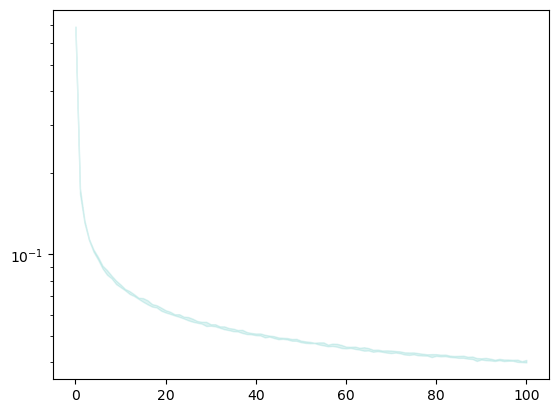

In [23]:
%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

fig, ax = plt.subplots()

hist = utils.load_results(dataset_name=f"binary_classification_synthetic_{n}x{d}",
                        model_name="linear",
                        scale=0,
                        batch_size=200, 
                        n_epochs=100,
                        optimizer="SANIA_identity",
                        lr=1.0,
                        seed=0)    
loss = hist["test/loss"]

x = np.linspace(0, loss.shape[0] - 1, loss.shape[0])
markevery = [x + np.random.randint(0, 5) for x in range(0, len(loss[0]), len(loss[0]) // 10)][:-1]


color = "lightseagreen"
linestyle = "-"
linewidth = 1.5
marker = "o"
label = r"SANIA $I_d$"

line, = plt.semilogy(loss, color=color, linestyle=linestyle, linewidth=linewidth, label=label)


def update(frame, x, y, line, err, max_l, min_l):
    line.set_data(x[:frame], y[:frame])
    err.set_data(x[:frame], max_l[:frame], min_l[:frame])
    return line,

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(x), interval=100, fargs=[x, mean_line, line, err, max_line, min_line], blit=True)
HTML(ani.to_jshtml())